In [3]:
from __future__ import print_function

# MNIST example

We will perform a simple analysis on MNIST to identify which pixels to erase to convert digits from one class into another class. We will compare importance scores computed using a variety of methods.

## Obtain data and keras model

We will load a keras model and compute importance scores

### Download the keras model

Download a model with 2 strided convolutional layers and 2 dense layers, similar to the one in the paper.

### Load the keras model

In [5]:
import torch
import keras
keras_model = keras.models.load_model("model/mnist_cnn_allconv.h5")
keras_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 13, 13)    544         convolution2d_input_3[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 13, 13)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 64, 5, 5)      32832       activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 64, 5, 5)      0           convolution2d_2[0][0]            
___________________________________________________________________________________________

### Load the data

In [6]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_test = X_test[:,None,:,:]
X_test = X_test / 255.

## Prepare the deeplift models

### Model conversion

Convert the keras models to deeplift models capable of computing importance scores using DeepLIFT-RevealCancel, gradients and guided backprop

In [7]:
import deeplift
from deeplift.blobs import NonlinearMxtsMode
from deeplift.conversion import keras_conversion as kc

#Three different models, one each for RevealCancel, Gradient and GuidedBackprop
revealcancel_model = kc.convert_sequential_model(model=keras_model, nonlinear_mxts_mode=NonlinearMxtsMode.RevealCancel)
grad_model = kc.convert_sequential_model(model=keras_model, nonlinear_mxts_mode=NonlinearMxtsMode.Gradient)
guided_backprop_model = kc.convert_sequential_model(model=keras_model, nonlinear_mxts_mode=NonlinearMxtsMode.GuidedBackprop)

nonlinear_mxts_mode is set to: RevealCancel
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case
nonlinear_mxts_mode is set to: Gradient
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case
nonlinear_mxts_mode is set to: GuidedBackprop
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case


### Sanity checks

To ensure that the conversion happend correctly, ensure that the models give identical predictions

In [8]:
from deeplift.util import compile_func
import numpy as np
from keras import backend as K

deeplift_model = revealcancel_model
deeplift_prediction_func = compile_func([deeplift_model.get_layers()[0].get_activation_vars()],
                                       deeplift_model.get_layers()[-1].get_activation_vars())
original_model_predictions = keras_model.predict(X_test, batch_size=200)
converted_model_predictions = deeplift.util.run_function_in_batches(
                                input_data_list=[X_test],
                                func=deeplift_prediction_func,
                                batch_size=200,
                                progress_update=None)
print("difference in predictions:",np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)))
assert np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)) < 10**-5
predictions = converted_model_predictions

INFO (theano.gof.compilelock): Refreshing lock /home/zzzace2000/.theano/compiledir_Linux-4.9--generic-x86_64-with-debian-stretch-sid-x86_64-2.7.13-64/lock_dir/lock


difference in predictions: 0.0


## Compute importance scores

### Compile various scoring functions

Using the deeplift models, we obtain the functions capable of computing the importance scores.

In [10]:
from keras import backend as K
import deeplift
from deeplift.util import get_integrated_gradients_function

revealcancel_func = revealcancel_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)
grad_times_inp_func = grad_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)
guided_backprop_times_inp_func = guided_backprop_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)

gradient_func = grad_model.get_target_multipliers_func(find_scores_layer_idx=0, target_layer_idx=-2)
guided_backprop_func = guided_backprop_model.get_target_multipliers_func(find_scores_layer_idx=0, target_layer_idx=-2)

#pure-gradients or pure-guidedbackprop perform rather poorly because they produce scores on pixels that are 0 (which are
#the backround in MNIST). But we can give them a slight advantage by masking out positions that
#are zero. Also, the method of simonyan et al uses the magnitude of the gradient.
simonyan_func_masked = lambda input_data_list, **kwargs: ((input_data_list[0]>0.0)*
                        np.abs(np.array(gradient_func(input_data_list=input_data_list,**kwargs))))
guided_backprop_func_masked = lambda input_data_list, **kwargs: ((input_data_list[0]>0.0)*
                               guided_backprop_func(input_data_list=input_data_list, **kwargs))

#prepare the integrated gradients scoring function
#heads-up: these take 5x and 10x longer to compute respectively!
integrated_grads_5 = get_integrated_gradients_function(gradient_func, 5)
integrated_grads_10 = get_integrated_gradients_function(gradient_func, 10)

INFO (theano.gof.compilelock): Refreshing lock /home/zzzace2000/.theano/compiledir_Linux-4.9--generic-x86_64-with-debian-stretch-sid-x86_64-2.7.13-64/lock_dir/lock


### Call scoring functions on the data

In [11]:
from collections import OrderedDict
method_to_task_to_scores = OrderedDict()
print("HEADS UP! integrated_grads_5 and integrated_grads_10 take 5x and 10x longer to run respectively")
print("Consider leaving them out to get faster results")
for method_name, score_func in [
                               ('revealcancel', revealcancel_func),
#                                ('guided_backprop_masked', guided_backprop_func_masked),
#                                ('guided_backprop_times_inp', guided_backprop_times_inp_func),
#                                ('simonyan_masked', simonyan_func_masked), 
#                                ('grad_times_inp', grad_times_inp_func),
#                                ('integrated_grads_5', integrated_grads_5),
#                                ('integrated_grads_10', integrated_grads_10)
]:
    print("Computing scores for:",method_name)
    method_to_task_to_scores[method_name] = {}
    for task_idx in range(10):
        print("\tComputing scores for task: "+str(task_idx))
        scores = np.array(score_func(
                    task_idx=task_idx,
                    input_data_list=[X_test],
                    input_references_list=[np.zeros_like(X_test)],
                    batch_size=1000,
                    progress_update=None))
        method_to_task_to_scores[method_name][task_idx] = scores

HEADS UP! integrated_grads_5 and integrated_grads_10 take 5x and 10x longer to run respectively
Consider leaving them out to get faster results
Computing scores for: revealcancel
	Computing scores for task: 0
	Computing scores for task: 1
	Computing scores for task: 2
	Computing scores for task: 3
	Computing scores for task: 4
	Computing scores for task: 5
	Computing scores for task: 6
	Computing scores for task: 7
	Computing scores for task: 8
	Computing scores for task: 9


In [13]:
import torch
torch.save(method_to_task_to_scores['revealcancel'], 'model/mnist_deeplift_scores.pth')

## Plot figures

### Prepare various functions to aid in plotting

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from keras import backend as K
import os

#Function to plot scores of an MNIST figure
def viz_scores(scores,ax):
    reshaped_scores = scores.reshape(28,28)
    the_min = np.min(reshaped_scores)
    the_max = np.max(reshaped_scores)
    center = 0.0
    negative_vals = (reshaped_scores < 0.0)*reshaped_scores/(the_min + 10**-7)
    positive_vals = (reshaped_scores > 0.0)*reshaped_scores/float(the_max)
    reshaped_scores = -negative_vals + positive_vals
    ax.imshow(-reshaped_scores, cmap="Greys")
    ax.set_xticks([])
    ax.set_yticks([])

#Function that masks out the top n pixels where the score for
#task_1 is higher than the score for task_2
def get_masked_image(idx, scores, task_1, task_2, n_to_erase):
    difference = scores[task_1][idx].ravel() - scores[task_2][idx].ravel()
    #highlight the top n
    top_nth_threshold = max(sorted(difference, key=lambda x: -x)[n_to_erase],0.0)
    thresholded_points = 1.0*(difference <= top_nth_threshold)
    masked_inp = thresholded_points.reshape(1,28,28)*X_test[idx]
    return masked_inp

#Function to plot the result of masking on a single example, for converting
#from task1->task2 and task1->task3
def plot_two_way_figures(idx, task_1, task_2, task_3, method_names, n_to_erase):
    print("example index: "+str(idx))
    print("Order of columns is:","task "+str(task_1)+" scores","task "+str(task_2)+" scores",
                                 str(task_1)+"->"+str(task_2)+" masking",
                                 "task "+str(task_3)+" scores", str(task_1)+"->"+str(task_3)+" masking")
    print("Order of the methods is: "+", ".join(str(x) for x in method_names))
    for method_name in method_names:
        scores = method_to_task_to_scores[method_name]
        mean_scores_over_all_tasks = np.mean(np.array([scores[i][idx] for i in range(10)]), axis=0)
        f, axarr = plt.subplots(1, 6, sharey=False, figsize=(15,10))
        viz_scores(X_test[idx], axarr[0])
        
        viz_scores(scores[task_1][idx] - mean_scores_over_all_tasks, axarr[1])
        viz_scores(scores[task_2][idx] - mean_scores_over_all_tasks, axarr[2])
        viz_scores(get_masked_image(idx, scores, task_1, task_2, n_to_erase), axarr[3])
        viz_scores(scores[task_3][idx] - mean_scores_over_all_tasks, axarr[4])
        viz_scores(get_masked_image(idx, scores, task_1, task_3, n_to_erase), axarr[5])
    plt.show()
    
#Function to compute change in log-odds scores after
#pixels have been masked to convert from original_class to target_class
def compute_delta_log_odds(X, y, predict_func, imp_scores,
                           original_class, target_class,
                           num_perturbations):
    original_class_mask = y_test==original_class
    X = np.compress(condition=original_class_mask,
                                  a=X,axis=0)
    
    
    #compute log-odds of model for those two classes
    predictions = np.array(deeplift.util.run_function_in_batches(predict_func,
                                                        input_data_list=[X],
                                                        batch_size=200, progress_update=None))
    orig_log_odds = predictions[:,original_class] - predictions[:,target_class]
    #make num_perturbations to move from original_class
    #to target_class according to imp_scores
    #first, get the difference of imp_scores for the two classes
    diff_of_scores = (np.compress(original_class_mask, imp_scores[original_class].reshape((-1, 784)), axis=0) - 
                      np.compress(original_class_mask, imp_scores[target_class].reshape((-1, 784)), axis=0))
    modified_inp = []
    #then, for each example, sort the scores and zero out indices
    for inp, diff_of_scores in zip(X, diff_of_scores):
        top_nth_threshold = max(sorted(diff_of_scores, key=lambda x: -x)[num_perturbations], 0.0)
        thresholded_points = 1.0*(diff_of_scores <= top_nth_threshold)
        modified_inp.append(thresholded_points.reshape(1,28,28)*inp)
    modified_inp = np.array(modified_inp)
    
    #assess change in log-odds for the modified images
    new_predictions = np.array(deeplift.util.run_function_in_batches(predict_func,
                                                        input_data_list=[modified_inp],
                                                        batch_size=200, progress_update=None))
    new_log_odds = new_predictions[:,original_class] - new_predictions[:,target_class]
    print(new_predictions)
    print(predictions)
    to_return = orig_log_odds - new_log_odds
    return (to_return,
            sum(new_log_odds < 0.0)/float(len(new_log_odds)),
            new_predictions[:,[original_class, target_class]],
            predictions[:,[original_class, target_class]])

#pre_softmax_func computes the output of the linear layer preceding the
#Final softmax noninearity
pre_softmax_func_inner = K.function([keras_model.input, K.learning_phase()],
                                    [keras_model.layers[-2].output])
pre_softmax_func = lambda x: pre_softmax_func_inner([x, False])[0]

def barplot_scores(original_class, target_class, method_names_and_short_names, n_to_erase):
    print("converting: "+str(original_class)+"->"+str(target_class))
    method_names = [x[0] for x in method_names_and_short_names]
    short_names = [x[1] for x in method_names_and_short_names]
    original_class_mask = y_test==original_class
    scores_to_plot = []
    fig, ax = plt.subplots(figsize=(2*len(method_names),5))
    
    for method_name in method_names:
        if method_name.startswith('p_b') or method_name.startswith('vbd'):
            path = 'result/deeplift-%d-%d-%s.pkl' % (original_class, target_class, method_name)
            if not os.path.exists(path):
                continue
            score = torch.load(path)
            scores_to_plot.append(score)
            continue

        logodds_diff, flipped, new_predictions, old_predictions = compute_delta_log_odds(
                                                                     X=X_test, y=y_test,
                                                                     predict_func=pre_softmax_func,
                                                                     imp_scores=method_to_task_to_scores[method_name],
                                                                     original_class=original_class,
                                                                     target_class=target_class,
                                                                     num_perturbations=n_to_erase)
        #figure out indices with big shifts
        retained_indices = np.compress(condition=original_class_mask, a=np.arange(len(y_test)))

        #sorted_shifts
        sorted_shifts = sorted(enumerate(zip(logodds_diff,new_predictions,old_predictions)), key=lambda x: -x[1][0])
        print("top indices for "+str(method_name)+": "+" ".join([str(retained_indices[x[0]]) for x in sorted_shifts[:10]]))
        scores_to_plot.append(logodds_diff)
    ax.boxplot(scores_to_plot, widths=[0.5 for x in method_names])
#     ax.set_ylim(-1000,17000)
    ax.set_ylabel("Change in log-odds")
    ax.set_xticklabels(short_names)
    plt.title(str(original_class)+" --> "+str(target_class), fontsize=24)
    plt.tick_params(labelsize=17)
    plt.show()
    return scores_to_plot

### Plot scores and result of masking on a single example

The example selected had the highest change in log-odds for 8->3 and second-highest for 8->6 according to grad_times_inp and integrated_gradients

example index: 5846
Order of columns is: task 8 scores task 3 scores 8->3 masking task 6 scores 8->6 masking
Order of the methods is: simonyan_masked, guided_backprop_masked, grad_times_inp, integrated_grads_10, revealcancel


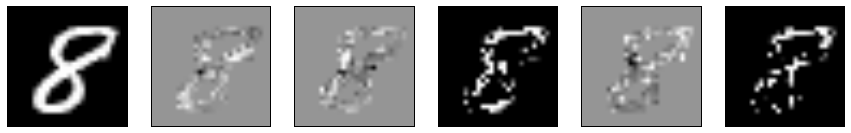

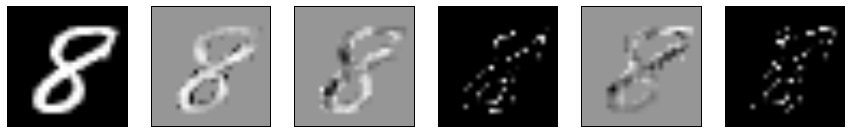

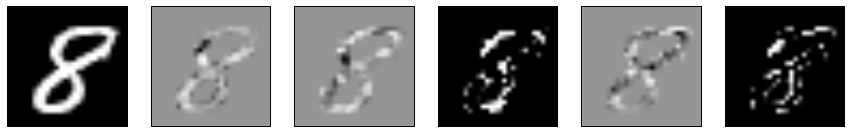

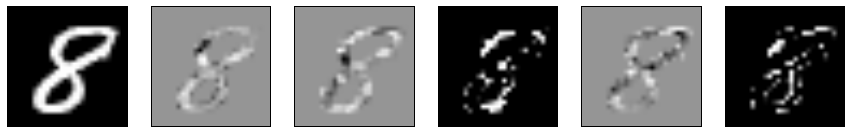

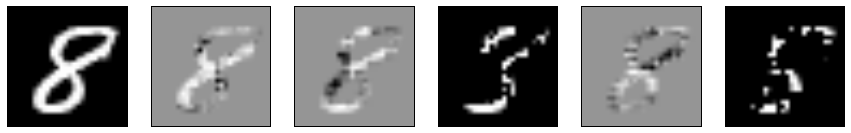

In [68]:
n_to_erase=157
method_names = ['simonyan_masked', 'guided_backprop_masked', 'grad_times_inp', 'integrated_grads_10', 'revealcancel']
plot_two_way_figures(5846,8,3,6,method_names,n_to_erase)

### Plot change in log-odds across all examples in a test set

converting: 8->3
[[-18.59174347   1.32586086   0.33380088 ...,  -2.5802002   -8.56227589
   -6.29256153]
 [-15.37352562  -2.96859527  -3.48815012 ...,  -0.7763676    0.05835028
   -4.77790356]
 [-13.43694782  -4.17150736  -8.01037025 ...,  -7.75288105  -1.02628517
    0.49064487]
 ..., 
 [ -8.13862705  -1.92739964  -5.23644304 ...,  -3.08672404  -3.96760845
   -0.24956253]
 [-16.1411171   -2.62710547  -9.59089947 ...,  -8.46810055  -3.26112008
    4.62384748]
 [-14.1702137   -6.82967377  -7.02704144 ...,  -6.74433708  -1.99194741
   -0.49957961]]
[[ -6.1481328  -18.2263298   -0.38299873 ..., -10.15057278  19.5954895
   -0.22920251]
 [-13.7472353  -11.133214   -14.26459503 ..., -12.70509815  19.72953415
   -5.08426905]
 [-11.9768858  -11.31201458  -1.53130281 ..., -15.20791435  23.79072952
   -8.01720142]
 ..., 
 [ -8.21369648   1.02289677  -5.92573595 ...,  -3.7745657   11.91007042
   -4.87044621]
 [-10.31448364 -13.21155262 -10.70760536 ..., -14.79552841  22.19445801
   -7.79141855]
 

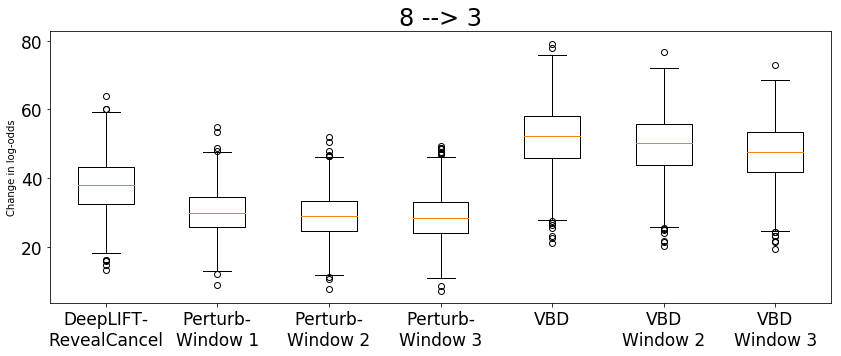

converting: 8->6
[[-8.43390846 -1.11298883  1.48722196 ..., -2.81475186 -4.03751373
  -6.2322917 ]
 [-4.4621191  -6.11800003 -3.52144814 ..., -9.21297073  2.34301925
  -6.39977598]
 [-6.18683815 -5.13302994 -0.49953869 ..., -5.34833002 -2.40629578
  -4.51492405]
 ..., 
 [-6.29972363 -0.85977983  2.05896068 ..., -0.98060638 -0.36081201
  -8.17302895]
 [-7.90776873 -5.91482449 -4.17928696 ..., -8.71099472 -3.42513585
   0.40896204]
 [-7.64666748 -5.71432209  0.45781288 ..., -2.82581091  0.68296742
  -7.98843241]]
[[ -6.1481328  -18.2263298   -0.38299873 ..., -10.15057278  19.5954895
   -0.22920251]
 [-13.7472353  -11.133214   -14.26459503 ..., -12.70509815  19.72953415
   -5.08426905]
 [-11.9768858  -11.31201458  -1.53130281 ..., -15.20791435  23.79072952
   -8.01720142]
 ..., 
 [ -8.21369648   1.02289677  -5.92573595 ...,  -3.7745657   11.91007042
   -4.87044621]
 [-10.31448364 -13.21155262 -10.70760536 ..., -14.79552841  22.19445801
   -7.79141855]
 [-10.28322411  -5.26007462  -7.54593

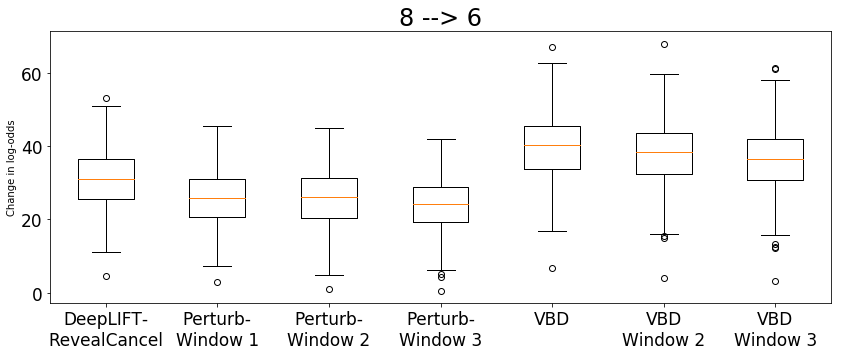

converting: 9->1
[[-9.53832245  4.4958539   6.41790962 ...,  0.54987311 -4.13271761
  -8.79336071]
 [-6.62602234  1.29605114  2.74865746 ...,  3.87779045  0.26417014
  -9.95671272]
 [-5.56421137  2.32403564  0.29405114 ...,  2.6777513  -0.39641887
  -3.85426092]
 ..., 
 [-6.59609509  0.65897602 -4.26527739 ..., -0.18350722  2.2453208
  -2.49011183]
 [-6.78198433  1.83981252  1.91743708 ...,  3.76073718  1.75706244
  -8.22792149]
 [-3.20289063  0.11836453  1.47738743 ...,  1.3568083   0.13974044
  -2.30372691]]
[[ -9.17103291  -7.20463848  -4.37001324 ...,  -9.8748703    3.69483662
   15.15949059]
 [-17.25566292 -16.50663757 -16.23501205 ...,  -1.86495817   1.31025255
   20.09705734]
 [-16.37196922 -13.3595705  -13.94572544 ...,  -4.85157108   0.37707338
   19.40475655]
 ..., 
 [-14.93449974  -7.5110383  -13.83981419 ...,   0.92115706  -0.16162574
   15.02424526]
 [-16.19757652 -11.66789627 -13.64043999 ...,  -3.99973822   1.64670491
   18.12372398]
 [-11.8896904  -15.87747574 -12.15123

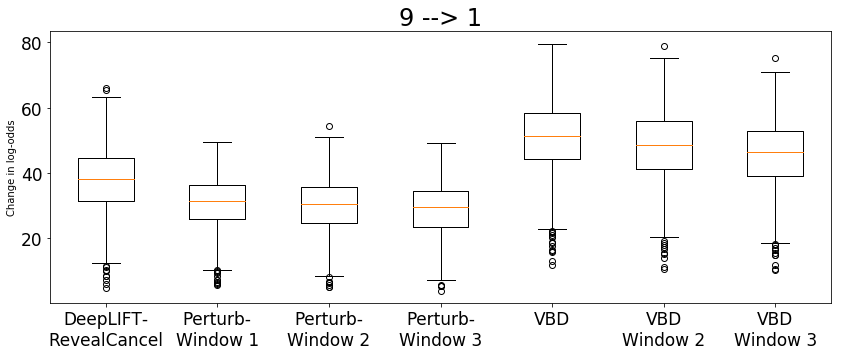

converting: 4->1
[[ -3.85166025   1.60744762   0.51839858 ...,   0.89601678   0.13021518
   -2.95587325]
 [ -4.38750219   2.0926435   -1.3805815  ...,  -1.8139987   -0.16215867
   -2.41400695]
 [ -5.08401489   0.96944869   0.76402205 ...,   2.06001639  -2.78820801
   -1.85812581]
 ..., 
 [ -4.96541357   2.12173271   3.48878431 ...,   5.31399632  -0.65744376
   -4.0923543 ]
 [-10.37646294   1.60349357   1.25025034 ...,   4.49879694  -4.84059429
   -5.89575052]
 [ -7.36012983   4.63666201   4.00171232 ...,   3.85803127  -1.98362732
  -10.09066677]]
[[ -8.04481602 -10.50258827  -7.91832113 ...,  -6.17970324  -2.53206801
    4.93096399]
 [-22.92034912  -2.2045722  -17.01988602 ...,  -5.41522646   3.15212607
    4.41115904]
 [-16.74801826  -1.44704211  -5.74228287 ...,  -0.82671046  -5.4620719
   -3.0736618 ]
 ..., 
 [-18.67310333  -4.64166117 -10.03663349 ...,  -0.29919165  -2.89667201
   -1.57631314]
 [-20.65877151  -5.44212818 -13.53272724 ...,  -5.12039614  -4.45230627
    0.85183048]
 

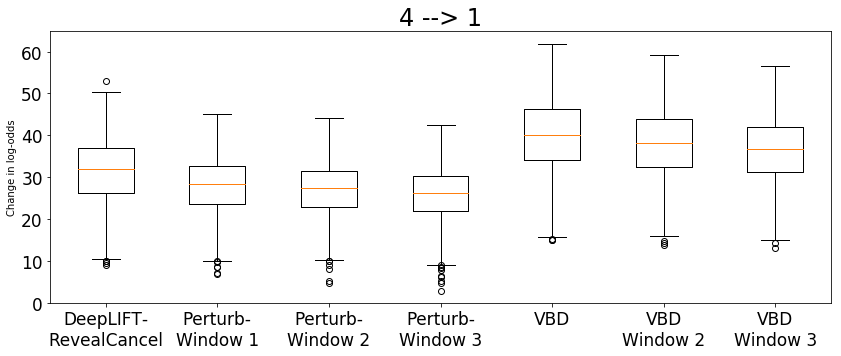

In [12]:
n_to_erase=157
method_names_and_short_names = [
#     ('simonyan_masked', '|grad|\n(Simonyan)'),
#     ('guided_backprop_masked', 'Guided\nBackprop'),
#     ('guided_backprop_times_inp', 'GBP*in'),
#     ('grad_times_inp', 'gradient\n*input'),
#     ('integrated_grads_5', 'integrated\ngrads-5'),
#     ('integrated_grads_10', 'integrated\ngrads-10'),
    ('revealcancel', 'DeepLIFT-\nRevealCancel'),
    ('p_b-1', 'Perturb-\nWindow 1'),
    ('p_b-2', 'Perturb-\nWindow 2'),
    ('p_b-3', 'Perturb-\nWindow 3'),
    ('vbd-1', 'VBD'),
    ('vbd_window-2', 'VBD\nWindow 2'),
    ('vbd_window-3', 'VBD\nWindow 3'),
]

scores = barplot_scores(8,3,method_names_and_short_names, n_to_erase)
barplot_scores(8,6,method_names_and_short_names, n_to_erase)
barplot_scores(9,1,method_names_and_short_names, n_to_erase)
scores = barplot_scores(4,1,method_names_and_short_names, n_to_erase)

converting: 8->3
[[-18.59174347   1.32586086   0.33380088 ...,  -2.5802002   -8.56227589
   -6.29256153]
 [-15.37352562  -2.96859527  -3.48815012 ...,  -0.7763676    0.05835028
   -4.77790356]
 [-13.43694782  -4.17150736  -8.01037025 ...,  -7.75288105  -1.02628517
    0.49064487]
 ..., 
 [ -8.13862705  -1.92739964  -5.23644304 ...,  -3.08672404  -3.96760845
   -0.24956253]
 [-16.1411171   -2.62710547  -9.59089947 ...,  -8.46810055  -3.26112008
    4.62384748]
 [-14.1702137   -6.82967377  -7.02704144 ...,  -6.74433708  -1.99194741
   -0.49957961]]
[[ -6.1481328  -18.2263298   -0.38299873 ..., -10.15057278  19.5954895
   -0.22920251]
 [-13.7472353  -11.133214   -14.26459503 ..., -12.70509815  19.72953415
   -5.08426905]
 [-11.9768858  -11.31201458  -1.53130281 ..., -15.20791435  23.79072952
   -8.01720142]
 ..., 
 [ -8.21369648   1.02289677  -5.92573595 ...,  -3.7745657   11.91007042
   -4.87044621]
 [-10.31448364 -13.21155262 -10.70760536 ..., -14.79552841  22.19445801
   -7.79141855]
 

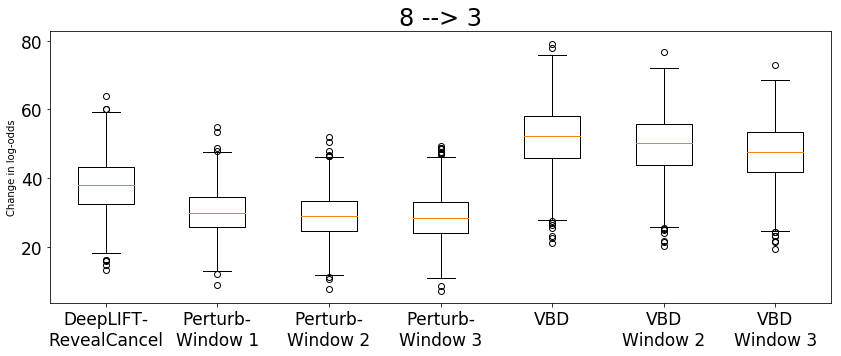

converting: 8->6
[[-8.43390846 -1.11298883  1.48722196 ..., -2.81475186 -4.03751373
  -6.2322917 ]
 [-4.4621191  -6.11800003 -3.52144814 ..., -9.21297073  2.34301925
  -6.39977598]
 [-6.18683815 -5.13302994 -0.49953869 ..., -5.34833002 -2.40629578
  -4.51492405]
 ..., 
 [-6.29972363 -0.85977983  2.05896068 ..., -0.98060638 -0.36081201
  -8.17302895]
 [-7.90776873 -5.91482449 -4.17928696 ..., -8.71099472 -3.42513585
   0.40896204]
 [-7.64666748 -5.71432209  0.45781288 ..., -2.82581091  0.68296742
  -7.98843241]]
[[ -6.1481328  -18.2263298   -0.38299873 ..., -10.15057278  19.5954895
   -0.22920251]
 [-13.7472353  -11.133214   -14.26459503 ..., -12.70509815  19.72953415
   -5.08426905]
 [-11.9768858  -11.31201458  -1.53130281 ..., -15.20791435  23.79072952
   -8.01720142]
 ..., 
 [ -8.21369648   1.02289677  -5.92573595 ...,  -3.7745657   11.91007042
   -4.87044621]
 [-10.31448364 -13.21155262 -10.70760536 ..., -14.79552841  22.19445801
   -7.79141855]
 [-10.28322411  -5.26007462  -7.54593

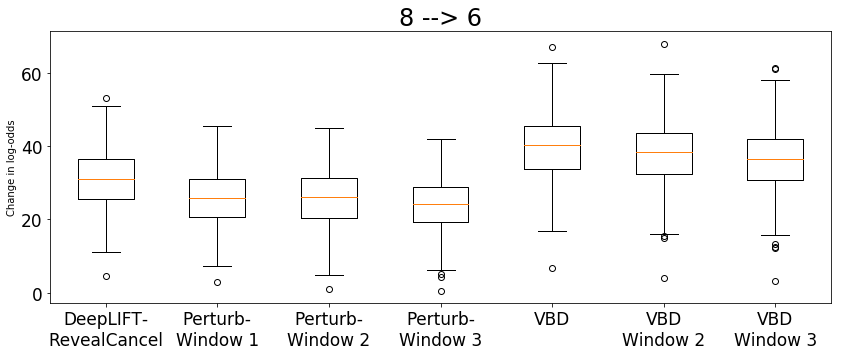

converting: 9->1
[[-9.53832245  4.4958539   6.41790962 ...,  0.54987311 -4.13271761
  -8.79336071]
 [-6.62602234  1.29605114  2.74865746 ...,  3.87779045  0.26417014
  -9.95671272]
 [-5.56421137  2.32403564  0.29405114 ...,  2.6777513  -0.39641887
  -3.85426092]
 ..., 
 [-6.59609509  0.65897602 -4.26527739 ..., -0.18350722  2.2453208
  -2.49011183]
 [-6.78198433  1.83981252  1.91743708 ...,  3.76073718  1.75706244
  -8.22792149]
 [-3.20289063  0.11836453  1.47738743 ...,  1.3568083   0.13974044
  -2.30372691]]
[[ -9.17103291  -7.20463848  -4.37001324 ...,  -9.8748703    3.69483662
   15.15949059]
 [-17.25566292 -16.50663757 -16.23501205 ...,  -1.86495817   1.31025255
   20.09705734]
 [-16.37196922 -13.3595705  -13.94572544 ...,  -4.85157108   0.37707338
   19.40475655]
 ..., 
 [-14.93449974  -7.5110383  -13.83981419 ...,   0.92115706  -0.16162574
   15.02424526]
 [-16.19757652 -11.66789627 -13.64043999 ...,  -3.99973822   1.64670491
   18.12372398]
 [-11.8896904  -15.87747574 -12.15123

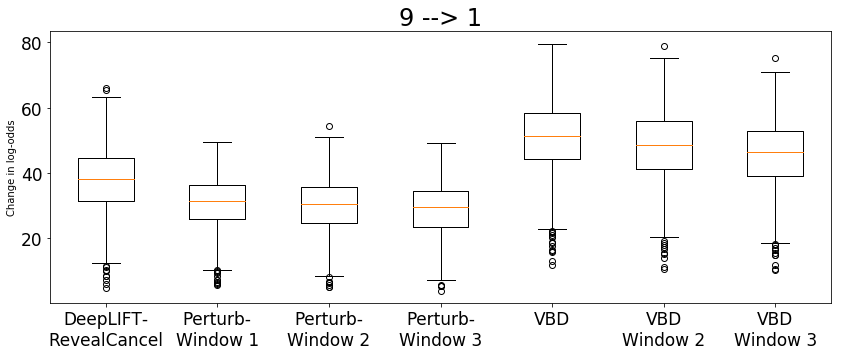

converting: 4->1
[[ -3.85166025   1.60744762   0.51839858 ...,   0.89601678   0.13021518
   -2.95587325]
 [ -4.38750219   2.0926435   -1.3805815  ...,  -1.8139987   -0.16215867
   -2.41400695]
 [ -5.08401489   0.96944869   0.76402205 ...,   2.06001639  -2.78820801
   -1.85812581]
 ..., 
 [ -4.96541357   2.12173271   3.48878431 ...,   5.31399632  -0.65744376
   -4.0923543 ]
 [-10.37646294   1.60349357   1.25025034 ...,   4.49879694  -4.84059429
   -5.89575052]
 [ -7.36012983   4.63666201   4.00171232 ...,   3.85803127  -1.98362732
  -10.09066677]]
[[ -8.04481602 -10.50258827  -7.91832113 ...,  -6.17970324  -2.53206801
    4.93096399]
 [-22.92034912  -2.2045722  -17.01988602 ...,  -5.41522646   3.15212607
    4.41115904]
 [-16.74801826  -1.44704211  -5.74228287 ...,  -0.82671046  -5.4620719
   -3.0736618 ]
 ..., 
 [-18.67310333  -4.64166117 -10.03663349 ...,  -0.29919165  -2.89667201
   -1.57631314]
 [-20.65877151  -5.44212818 -13.53272724 ...,  -5.12039614  -4.45230627
    0.85183048]
 

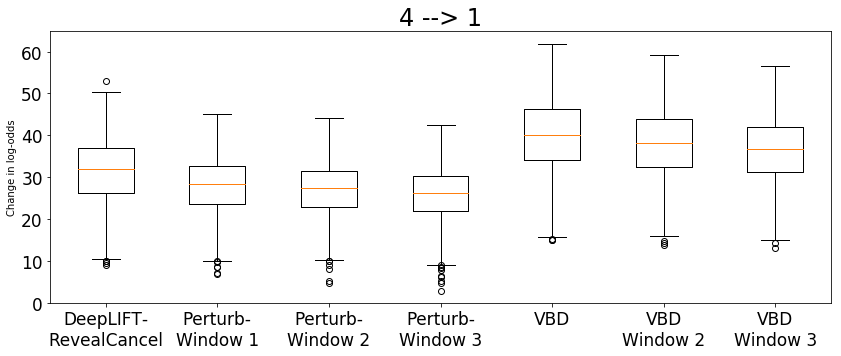

In [10]:
n_to_erase=157
method_names_and_short_names = [
#     ('simonyan_masked', '|grad|\n(Simonyan)'),
#     ('guided_backprop_masked', 'Guided\nBackprop'),
#     ('guided_backprop_times_inp', 'GBP*in'),
#     ('grad_times_inp', 'gradient\n*input'),
#     ('integrated_grads_5', 'integrated\ngrads-5'),
#     ('integrated_grads_10', 'integrated\ngrads-10'),
    ('revealcancel', 'DeepLIFT-\nRevealCancel'),
    ('p_b-1', 'Perturb-\nWindow 1'),
    ('p_b-2', 'Perturb-\nWindow 2'),
    ('p_b-3', 'Perturb-\nWindow 3'),
    ('vbd-1', 'VBD'),
    ('vbd_window-2', 'VBD\nWindow 2'),
    ('vbd_window-3', 'VBD\nWindow 3'),
]

scores = barplot_scores(8,3,method_names_and_short_names, n_to_erase)
barplot_scores(8,6,method_names_and_short_names, n_to_erase)cv
barplot_scores(9,1,method_names_and_short_names, n_to_erase)
scores = barplot_scores(4,1,method_names_and_short_names, n_to_erase)

converting: 8->3
[[-18.59174538   1.32586026   0.33380085 ...,  -2.5802002   -8.56227684
   -6.29256153]
 [-15.37352371  -2.9685955   -3.48814964 ...,  -0.77636731   0.05835037
   -4.77790308]
 [-13.43694782  -4.17150593  -8.01037216 ...,  -7.75288057  -1.02628565
    0.49064469]
 ..., 
 [ -8.13862514  -1.92739964  -5.23644304 ...,  -3.08672404  -3.96760798
   -0.24956214]
 [-16.1411171   -2.62710595  -9.59089851 ...,  -8.46810055  -3.26112103
    4.62384748]
 [-14.1702137   -6.82967281  -7.02704048 ...,  -6.74433708  -1.99194765
   -0.49957979]]
[[ -6.1481328  -18.2263279   -0.38299718 ..., -10.15057182  19.5954895
   -0.22920227]
 [-13.74723625 -11.13321304 -14.26459503 ..., -12.7050972   19.72953033
   -5.08426857]
 [-11.9768877  -11.31201363  -1.53130364 ..., -15.20791626  23.79072952
   -8.01720047]
 ..., 
 [ -8.21369648   1.02289712  -5.92573643 ...,  -3.7745657   11.91007137
   -4.87044668]
 [-10.31448364 -13.21154881 -10.70760536 ..., -14.79552841  22.19445801
   -7.79141808]
 

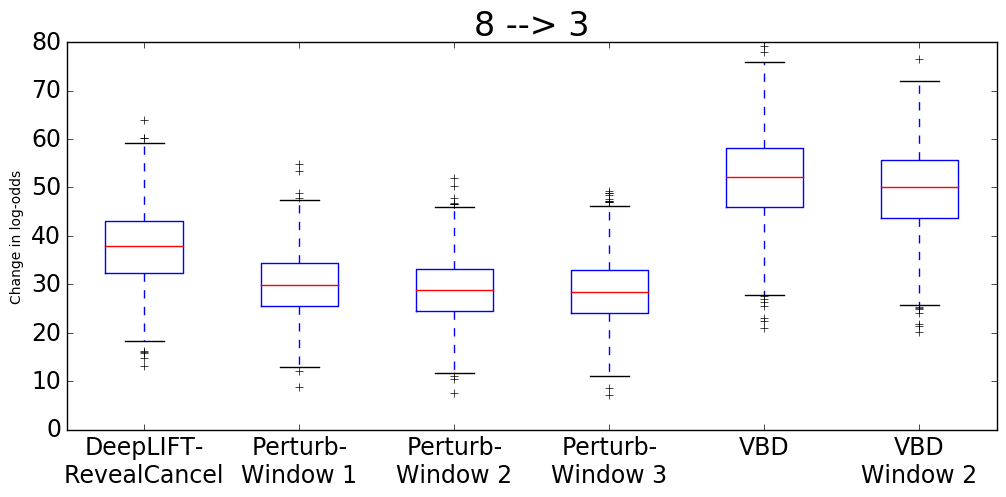

converting: 8->6
[[-8.43390846 -1.11298931  1.48722196 ..., -2.81475186 -4.03751326
  -6.23229122]
 [-4.46211863 -6.11800146 -3.52144861 ..., -9.21297169  2.34301925
  -6.39977551]
 [-6.18683815 -5.13302994 -0.4995383  ..., -5.3483305  -2.40629506
  -4.51492357]
 ..., 
 [-6.29972267 -0.85977995  2.05896115 ..., -0.98060602 -0.36081201
  -8.17302895]
 [-7.90776777 -5.91482449 -4.17928696 ..., -8.71099377 -3.42513585
   0.40896207]
 [-7.64666796 -5.71432209  0.45781258 ..., -2.82581067  0.68296742
  -7.98843241]]
[[ -6.1481328  -18.2263279   -0.38299718 ..., -10.15057182  19.5954895
   -0.22920227]
 [-13.74723625 -11.13321304 -14.26459503 ..., -12.7050972   19.72953033
   -5.08426857]
 [-11.9768877  -11.31201363  -1.53130364 ..., -15.20791626  23.79072952
   -8.01720047]
 ..., 
 [ -8.21369648   1.02289712  -5.92573643 ...,  -3.7745657   11.91007137
   -4.87044668]
 [-10.31448364 -13.21154881 -10.70760536 ..., -14.79552841  22.19445801
   -7.79141808]
 [-10.28322506  -5.26007366  -7.54593

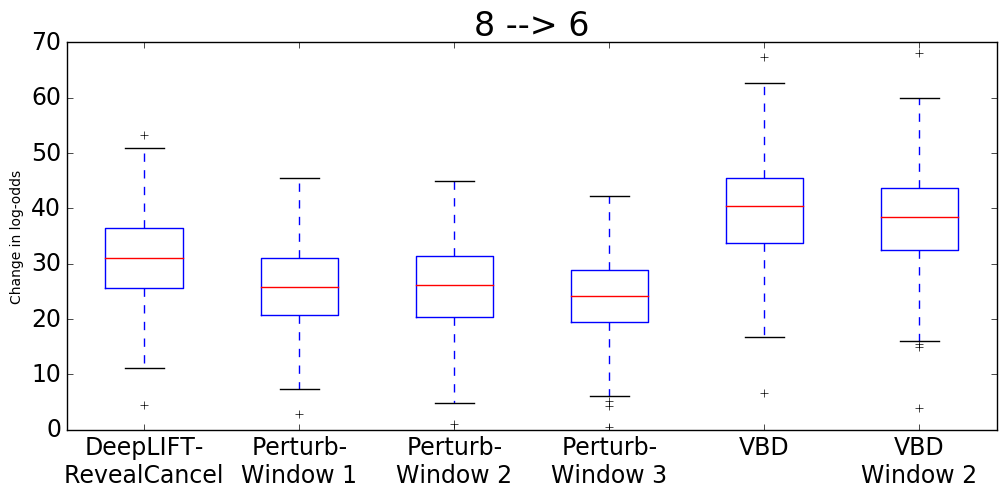

converting: 9->1
[[-9.5383215   4.49585533  6.41790962 ...,  0.54987311 -4.13271809
  -8.79336166]
 [-6.62602234  1.29605091  2.74865699 ...,  3.87779045  0.26417017
  -9.95671272]
 [-5.56421089  2.32403612  0.29405117 ...,  2.6777513  -0.39641875
  -3.8542614 ]
 ..., 
 [-6.59609509  0.65897608 -4.26527739 ..., -0.18350738  2.24532175
  -2.49011159]
 [-6.78198433  1.83981252  1.91743743 ...,  3.76073694  1.75706244
  -8.22792053]
 [-3.2028904   0.11836451  1.47738731 ...,  1.35680807  0.13974044
  -2.30372691]]
[[ -9.17103291  -7.204638    -4.37001324 ...,  -9.87486935   3.69483662
   15.15948963]
 [-17.25566483 -16.50663567 -16.23501205 ...,  -1.86495781   1.31025243
   20.09705925]
 [-16.37196922 -13.35956955 -13.94572639 ...,  -4.85157204   0.37707403
   19.40475655]
 ..., 
 [-14.93449688  -7.51103878 -13.83981419 ...,   0.92115766  -0.1616255
   15.02424431]
 [-16.19757652 -11.66789436 -13.64043999 ...,  -3.99973822   1.64670479
   18.12372208]
 [-11.88968945 -15.87747574 -12.15123

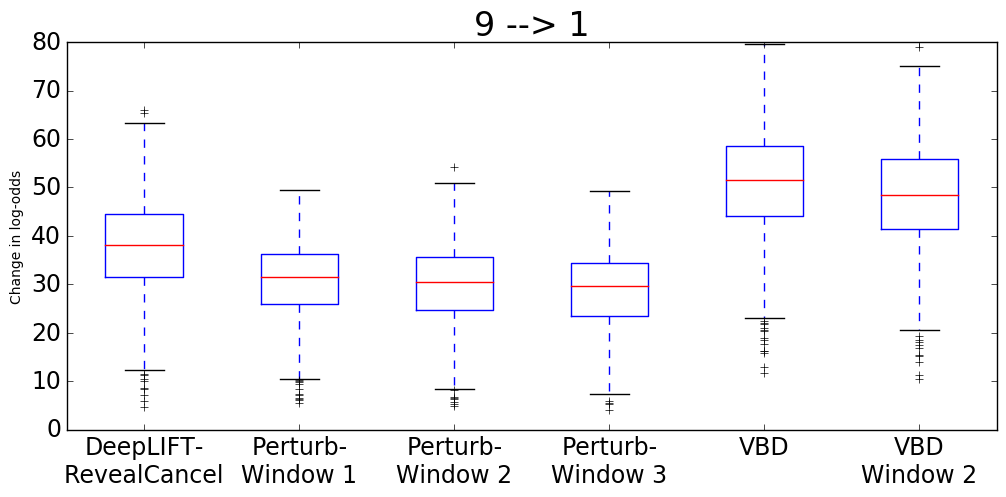

converting: 4->1
[[ -3.85166073   1.60744762   0.51839852 ...,   0.89601678   0.13021511
   -2.95587325]
 [ -4.38750172   2.09264326  -1.38058126 ...,  -1.8139987   -0.16215858
   -2.41400695]
 [ -5.08401442   0.96944857   0.76402187 ...,   2.06001639  -2.78820825
   -1.85812581]
 ..., 
 [ -4.96541452   2.12173247   3.48878336 ...,   5.31399727  -0.6574437
   -4.0923543 ]
 [-10.37646198   1.60349333   1.25025094 ...,   4.49879789  -4.84059381
   -5.89575052]
 [ -7.36012793   4.63666058   4.00171232 ...,   3.85803175  -1.9836278
  -10.09066772]]
[[ -8.04481697 -10.50258827  -7.91832113 ...,  -6.17970371  -2.53206778
    4.93096447]
 [-22.92035103  -2.20457125 -17.01988792 ...,  -5.41522598   3.15212679
    4.41116047]
 [-16.74801826  -1.44704211  -5.74228287 ...,  -0.82671052  -5.4620719
   -3.0736618 ]
 ..., 
 [-18.67310333  -4.64166164 -10.03663635 ...,  -0.29919255  -2.89667225
   -1.5763135 ]
 [-20.6587677   -5.44212818 -13.53272629 ...,  -5.12039661  -4.45230579
    0.85183126]
 [-

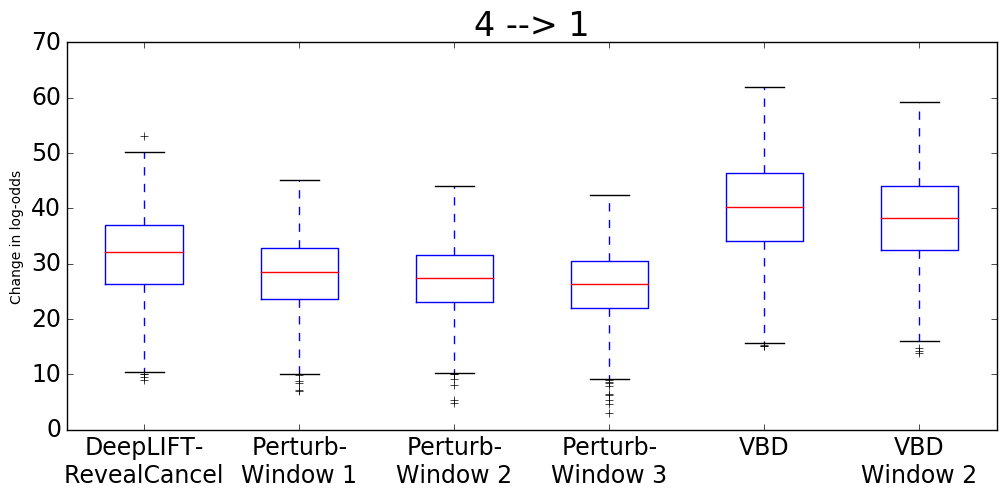

In [24]:
n_to_erase=157
method_names_and_short_names = [
#     ('simonyan_masked', '|grad|\n(Simonyan)'),
#     ('guided_backprop_masked', 'Guided\nBackprop'),
#     ('guided_backprop_times_inp', 'GBP*in'),
#     ('grad_times_inp', 'gradient\n*input'),
#     ('integrated_grads_5', 'integrated\ngrads-5'),
#     ('integrated_grads_10', 'integrated\ngrads-10'),
    ('revealcancel', 'DeepLIFT-\nRevealCancel'),
    ('p_b-1', 'Perturb-\nWindow 1'),
    ('p_b-2', 'Perturb-\nWindow 2'),
    ('p_b-3', 'Perturb-\nWindow 3'),
    ('vbd-1', 'VBD'),
    ('vbd_window-2', 'VBD\nWindow 2'),
    ('vbd_window-3', 'VBD\nWindow 3'),
]

scores = barplot_scores(8,3,method_names_and_short_names, n_to_erase)
barplot_scores(8,6,method_names_and_short_names, n_to_erase)
barplot_scores(9,1,method_names_and_short_names, n_to_erase)
scores = barplot_scores(4,1,method_names_and_short_names, n_to_erase)